In [3]:
"""# authenticate google drive
from google.colab import drive
drive.mount('/content/drive')
"""

"# authenticate google drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [4]:
# install necessary libraries
#!pip install pyrsgis

In [41]:
# import all the required libraries
import os, glob, re, time
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from copy import deepcopy
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Polygon

#os.chdir(r'/content/drive/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')
os.chdir(r'G:/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')

In [2]:
# define a function for alphanumeric filename sorting
def sorted_nicely(l): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [3]:
# read dataframe
df = pd.read_csv('210803_Kathmandu_UGM_GWLR.zip', compression='zip')
#df.columns = [a.split('@')[0] for a in df.keys()]

# generate built-up layers
for year in [2000, 2010, 2020]:
  df['%d_built'%year] = (df['%d_landcover' % (year)] == 1).astype(int)

df['growth_00_10'] = df['2010_built'] - df['2000_built']
df['growth_10_20'] = df['2020_built'] - df['2010_built']

df = df[sorted_nicely(df.keys())]

print(df.keys())

Index(['2000_AD_K5', '2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9',
       '2000_BD_K11', '2000_BD_K13', '2000_VD_K5', '2000_built',
       '2000_dist_builtup', '2000_landcover', '2000_r1_dist', '2000_r2_dist',
       '2000_r3_dist', '2010_AD_K5', '2010_BD_K3', '2010_BD_K5', '2010_BD_K7',
       '2010_BD_K9', '2010_BD_K11', '2010_BD_K13', '2010_VD_K5', '2010_built',
       '2010_dist_builtup', '2010_landcover', '2010_r1_dist', '2010_r2_dist',
       '2010_r3_dist', '2020_AD_K5', '2020_BD_K3', '2020_BD_K5', '2020_BD_K7',
       '2020_BD_K9', '2020_BD_K11', '2020_BD_K13', '2020_VD_K5', '2020_built',
       '2020_dist_builtup', '2020_landcover', '2020_r1_dist', '2020_r2_dist',
       '2020_r3_dist', 'dist_bus_stops', 'dist_hospitals', 'dist_hotels',
       'dist_institutes', 'dist_water', 'elevation', 'growth_00_10',
       'growth_10_20', 'latitudes', 'longitudes', 'slope'],
      dtype='object')


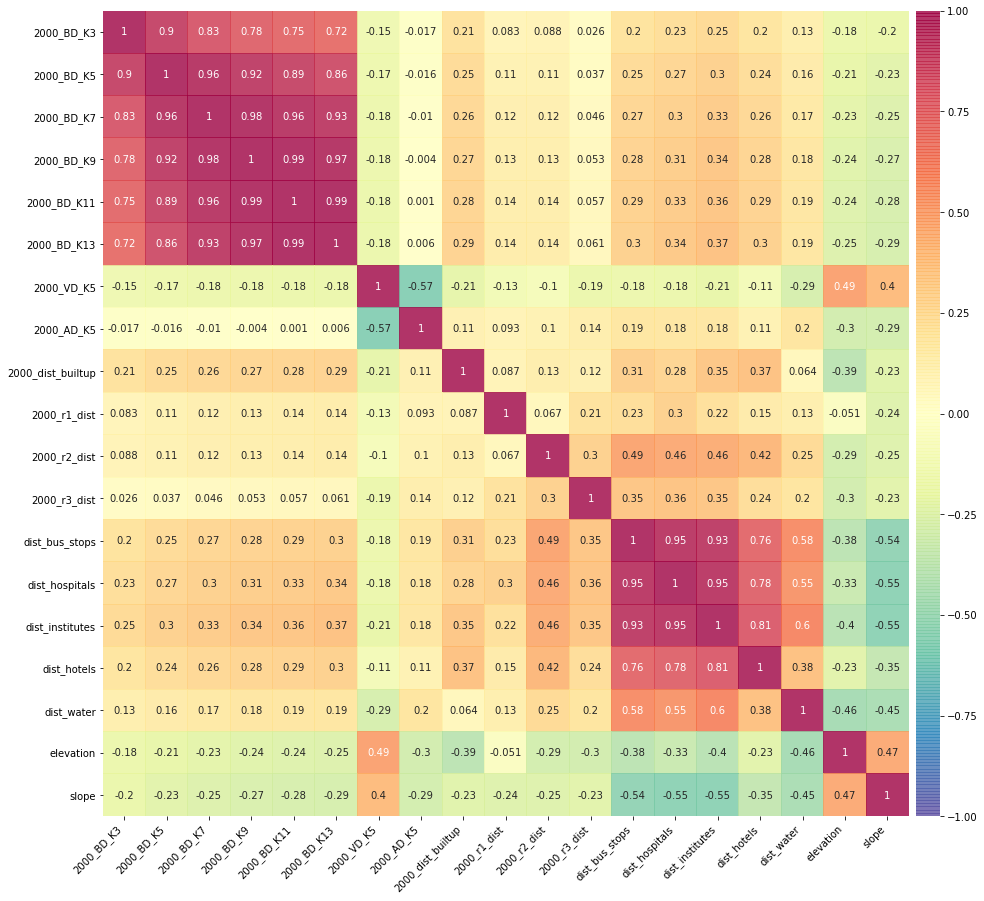

In [12]:
fig = None
ax = None

# create dataframe for epoch 1 
df_epoch1 = df[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_built', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
       '2000_r1_dist', '2000_r2_dist', '2000_r3_dist', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope', 'growth_00_10']]

# extract non-builtup cells only and remove builtup column
df_epoch1 = df_epoch1.loc[df_epoch1['2000_built'] == 0]
growth_00_10 = df_epoch1['growth_00_10']
df_epoch1.drop(['2000_built', 'growth_00_10'], axis=1, inplace=True)

# plot correlation matrix for epoch 1
corr1 = df_epoch1.corr()
corr1 = np.round(corr1, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (15, 15))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr1,
    vmin=-1, vmax=1, center=0,
    cmap='Spectral_r',#sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax,
    alpha=0.8
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.savefig(r'Images/%s_CorrMat_Epoch1_PT_V3.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
plt.show()

In [13]:
corr1[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1).loc[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']]

dist_bus_stops     0.961000
dist_hospitals     0.966333
dist_institutes    0.961333
dtype: float64

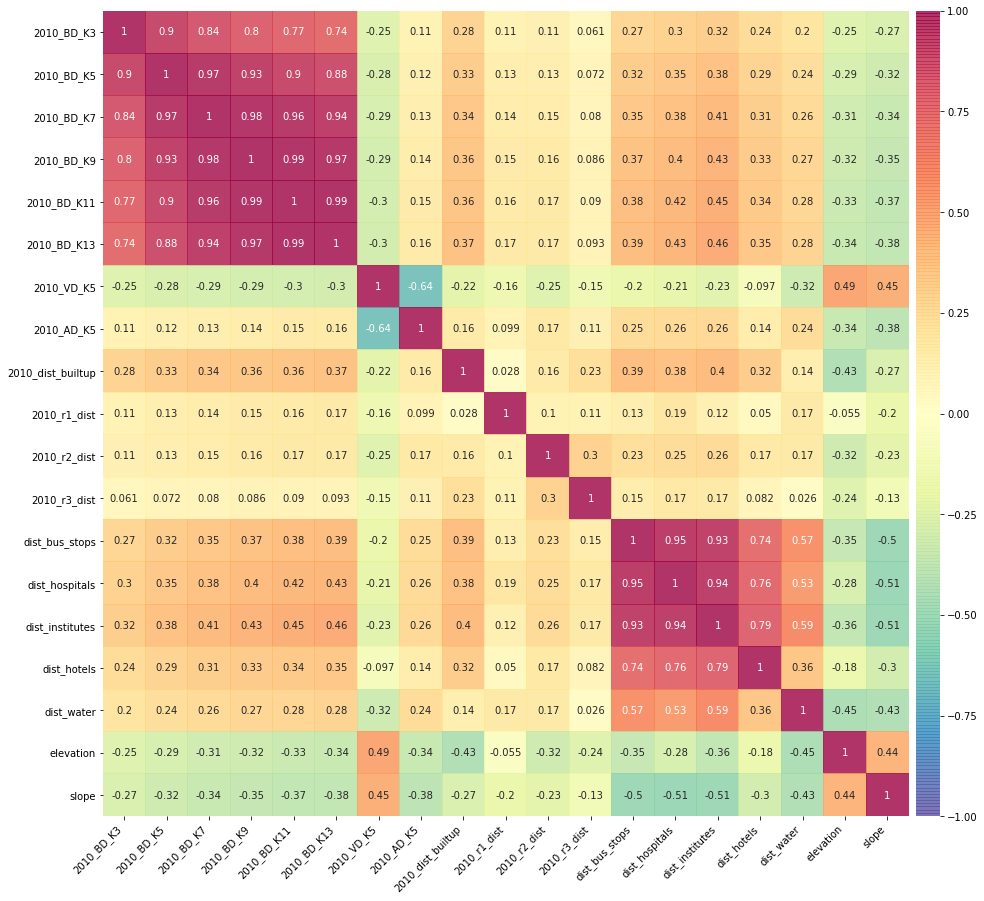

In [15]:
fig = None
ax = None

# create dataframe for epoch 1 
df_epoch2 = df[['2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_built', '2010_VD_K5', '2010_AD_K5', '2010_dist_builtup',
       '2010_r1_dist', '2010_r2_dist', '2010_r3_dist', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope', 'growth_10_20']]

# extract non-builtup cells only and remove builtup column
df_epoch2 = df_epoch2.loc[df_epoch2['2010_built'] == 0]
growth_10_20 = df_epoch2['growth_10_20']
df_epoch2.drop(['2010_built', 'growth_10_20'], axis=1, inplace=True)

# plot correlation matrix for epoch 1
corr2 = df_epoch2.corr()
corr2 = np.round(corr2, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (15, 15))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr2,
    vmin=-1, vmax=1, center=0,
    cmap='Spectral_r',#sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax,
    alpha=0.8
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.savefig(r'Images/%s_CorrMat_Epoch2_PT_V3.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
plt.show()

In [16]:
corr2[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1).loc[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']]

dist_bus_stops     0.959667
dist_hospitals     0.964000
dist_institutes    0.959000
dtype: float64

## Remove highly correlated features and class balance the data

In [17]:
N_SAMPLES = 25000

# remove the ones with correlation more than 0.75
# retain dist_institutes because that has the highest correlation with distance to bus stops, hospitals and hotels
df_epoch1_reduced = df_epoch1[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
       '2000_r1_dist', '2000_r2_dist', '2000_r3_dist', 
       'dist_hospitals', 'dist_hotels', 'dist_water', 'elevation', 
       'slope']]

df_epoch2_reduced = df_epoch2[['2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_VD_K5', '2010_AD_K5', '2010_dist_builtup',
       '2010_r1_dist', '2010_r2_dist', '2010_r3_dist',
       'dist_hospitals', 'dist_hotels', 'dist_water', 'elevation', 
       'slope']]

## Class balance the features for epoch 1
# Separate and balance the classes
built_features = df_epoch1_reduced.loc[growth_00_10==1]
built_labels = growth_00_10.loc[growth_00_10==1]

unbuilt_features = df_epoch1_reduced.loc[growth_00_10==0]
unbuilt_labels = growth_00_10.loc[growth_00_10==0]

print('Epoch 1 - Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Downsample the majority class
unbuilt_features = resample(unbuilt_features,
                            replace = False, # sample without replacement
                            n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(unbuilt_labels,
                          replace = False, # sample without replacement
                          n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                          random_state = 2)

built_features = resample(built_features,
                            replace = False, # sample without replacement
                            n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                            random_state = 2)

built_labels = resample(built_labels,
                          replace = False, # sample without replacement
                          n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                          random_state = 2)

print('Epoch 1 - Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Combine the balanced features
df_epoch1_reduced = pd.concat([built_features, unbuilt_features], axis=0)
growth_00_10_bal = pd.concat([built_labels, unbuilt_labels], axis=0)

## Class balance the features for epoch 2
# Separate and balance the classes
built_features = df_epoch2_reduced.loc[growth_10_20==1]
built_labels = growth_10_20.loc[growth_10_20==1]

unbuilt_features = df_epoch2_reduced.loc[growth_10_20==0]
unbuilt_labels = growth_10_20.loc[growth_10_20==0]

print('\nEpoch 2 - Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Downsample the majority class
unbuilt_features = resample(unbuilt_features,
                            replace = False, # sample without replacement
                            n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(unbuilt_labels,
                          replace = False, # sample without replacement
                          n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                          random_state = 2)

built_features = resample(built_features,
                            replace = False, # sample without replacement
                            n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                            random_state = 2)

built_labels = resample(built_labels,
                          replace = False, # sample without replacement
                          n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                          random_state = 2)

print('Epoch 2 - Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Combine the balanced features
df_epoch2_reduced = pd.concat([built_features, unbuilt_features], axis=0)
growth_10_20_bal = pd.concat([built_labels, unbuilt_labels], axis=0)

Epoch 1 - Number of records in each class:
Built: 70529, Unbuilt: 856020
Epoch 1 - Number of records in balanced classes:
Built: 12500, Unbuilt: 12500

Epoch 2 - Number of records in each class:
Built: 53042, Unbuilt: 802978
Epoch 2 - Number of records in balanced classes:
Built: 12500, Unbuilt: 12500


## Check distribution of features

In [18]:
# compute mean and standard deviation for both the epochs separately
mean_vals_e1 = df_epoch1_reduced.mean(axis=0)
std_vals_e1 = df_epoch1_reduced.std(axis=0)

mean_vals_e2 = df_epoch2_reduced.mean(axis=0)
std_vals_e2 = df_epoch2_reduced.std(axis=0)

# standarise data for both the epochs
for covariate in df_epoch1_reduced.keys():
    df_epoch1_reduced[covariate] = (df_epoch1_reduced[covariate] - mean_vals_e1[covariate]) / std_vals_e1[covariate]
    
for covariate in df_epoch2_reduced.keys():
    #print(covariate, round(mean_vals_e2[covariate], 3), round(std_vals_e2[covariate]))
    df_epoch2_reduced[covariate] = (df_epoch2_reduced[covariate] - mean_vals_e2[covariate]) / std_vals_e2[covariate]
    
df_epoch1_reduced.describe()

,2000_BD_K3,2000_BD_K5,2000_BD_K7,2000_BD_K9,2000_BD_K11,2000_BD_K13,2000_VD_K5,2000_AD_K5,2000_dist_builtup,2000_r1_dist,2000_r2_dist,2000_r3_dist,dist_hospitals,dist_hotels,dist_water,elevation,slope
count,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04
mean,5.229595e-17,-4.888534e-17,-1.205080e-16,-1.546141e-16,-9.549694e-17,3.637979e-17,-5.684342e-18,1.605827e-17,-4.706635e-16,-3.967671e-16,-2.285105e-16,1.773515e-16,-3.956302e-16,-1.659828e-16,-6.025402e-17,-2.501110e-17,2.501110e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.529432e-01,-5.062747e-01,-5.319313e-01,-5.473235e-01,-5.586738e-01,-5.674506e-01,-7.844475e-01,-6.545642e-01,-5.144611e+00,-4.497817e+00,-4.225848e+00,-3.052499e+00,-3.774879e+00,-4.048488e+00,-3.916798e+00,-2.261446e+00,-1.188161e+00
25%,-4.529432e-01,-5.062747e-01,-5.319313e-01,-5.473235e-01,-5.586738e-01,-5.674506e-01,-7.844475e-01,-6.545642e-01,-1.930777e-01,-2.406314e-01,-1.656472e-01,-2.545471e-01,-6.774257e-01,-5.427303e-01,-2.988449e-01,-5.882391e-01,-8.146763e-01
50%,-4.529432e-01,-5.062747e-01,-5.319313e-01,-5.473235e-01,-5.105798e-01,-4.988324e-01,-7.844475e-01,-6.545642e-01,4.840550e-01,3.396620e-01,4.216107e-01,4.674209e-01,3.823120e-01,3.030278e-01,3.935863e-01,-4.227985e-01,-3.569056e-01
75%,-4.529432e-01,-1.720545e-02,7.317421e-02,1.028451e-01,1.146427e-01,1.187315e-01,9.376894e-01,6.799980e-01,6.110178e-01,6.502925e-01,5.903631e-01,6.478849e-01,8.314941e-01,7.753315e-01,6.705587e-01,2.690441e-01,6.572511e-01
max,5.473693e+00,5.362556e+00,5.277081e+00,5.231953e+00,5.212610e+00,5.127861e+00,1.748107e+00,3.052553e+00,6.533383e-01,8.539870e-01,6.928275e-01,6.979009e-01,1.065135e+00,1.172207e+00,8.609772e-01,4.626901e+00,5.513485e+00


In [10]:
df_epoch2_reduced.describe()

,2010_BD_K3,2010_BD_K5,2010_BD_K7,2010_BD_K9,2010_BD_K11,2010_BD_K13,2010_VD_K5,2010_AD_K5,2010_dist_builtup,2010_r1_dist,2010_r2_dist,2010_r3_dist,dist_hospitals,dist_hotels,dist_water,elevation,slope
count,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04
mean,1.136868e-17,4.320100e-17,7.275958e-17,2.046363e-17,-1.091394e-16,1.750777e-16,-3.865352e-17,1.136868e-16,-4.865797e-16,3.592504e-16,-2.205525e-16,8.810730e-18,-1.978151e-16,-1.000444e-16,-7.275958e-16,-3.001333e-16,-2.273737e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.602971e-01,-6.343933e-01,-6.705411e-01,-6.929374e-01,-7.093240e-01,-7.217992e-01,-6.966223e-01,-8.434158e-01,-6.482377e+00,-4.816484e+00,-4.293940e+00,-3.467607e+00,-3.812660e+00,-4.012700e+00,-3.914539e+00,-2.219385e+00,-1.218092e+00
25%,-5.602971e-01,-6.343933e-01,-6.705411e-01,-6.929374e-01,-7.093240e-01,-7.217992e-01,-6.966223e-01,-8.434158e-01,-1.357456e-01,-2.696608e-01,-1.559426e-01,3.698705e-03,-6.760292e-01,-5.159800e-01,-3.021352e-01,-5.944520e-01,-8.322023e-01
50%,-5.602971e-01,-6.343933e-01,-5.754601e-01,-5.225134e-01,-5.204192e-01,-5.061104e-01,-6.966223e-01,-8.434158e-01,4.509183e-01,2.877008e-01,3.606043e-01,3.979543e-01,3.687537e-01,3.054421e-01,3.925580e-01,-4.386365e-01,-3.361365e-01
75%,2.160000e-02,3.236848e-01,3.753490e-01,3.864150e-01,4.241049e-01,4.375279e-01,9.057661e-01,8.741954e-01,6.109171e-01,6.638425e-01,5.898588e-01,5.320507e-01,8.047285e-01,7.396687e-01,6.878025e-01,3.738304e-01,6.997211e-01
max,4.094880e+00,3.964382e+00,3.893343e+00,3.851704e+00,3.824391e+00,3.807665e+00,1.807110e+00,2.459683e+00,6.109171e-01,9.536283e-01,7.300262e-01,5.914702e-01,1.146504e+00,1.270225e+00,8.788430e-01,4.573430e+00,4.959864e+00


In [19]:
# Use the following mean and std for scaling features for prediction
epoch2_mean_std = pd.concat([mean_vals_e2, std_vals_e2], axis=1)
epoch2_mean_std.columns = ['mean', 'sd']
epoch2_mean_std.reset_index(drop=False, inplace=True)
epoch2_mean_std.columns = ['Variable', 'Mean', 'SD']

print(epoch2_mean_std)
epoch2_mean_std.to_csv(r'output\%s_Kathmandu_Epoch2_Mean_SD_PT_V1.csv' % (datetime.now().strftime('%y%m%d')))

             Variable      Mean        SD
0          2010_BD_K3  0.106987  0.190946
1          2010_BD_K5  0.132430  0.208751
2          2010_BD_K7  0.143925  0.214640
3          2010_BD_K9  0.150591  0.217323
4         2010_BD_K11  0.155162  0.218747
5         2010_BD_K13  0.158413  0.219470
6          2010_VD_K5  0.278234  0.399404
7          2010_AD_K5  0.255341  0.302746
8   2010_dist_builtup  0.917592  0.134893
9        2010_r1_dist  0.834730  0.173307
10       2010_r2_dist  0.854691  0.199046
11       2010_r3_dist  0.854285  0.246361
12     dist_hospitals  0.768811  0.201647
13        dist_hotels  0.762639  0.186865
14         dist_water  0.816655  0.208621
15          elevation  0.332029  0.144531
16              slope  0.179369  0.147254


## Grid search to find the best Lasso Logistic Model for both epochs

In [12]:
# perform the grid search to find the right parameters
param_grid = [
    {'C': [1, 2, 3, 4, 5]}
]

# set up grid search for the Epoch 2
logit_epoch1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
grid_search_epoch1 = GridSearchCV(logit_epoch1, param_grid, cv=5, scoring='f1', n_jobs=-1)

# set up grid search for the Epoch 2
logit_epoch2 = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
grid_search_epoch2 = GridSearchCV(logit_epoch2, param_grid, cv=5, scoring='f1', n_jobs=-1)

# run the grid search for both the epochs
grid_search_epoch1.fit(df_epoch1_reduced, growth_00_10_bal)
grid_search_epoch2.fit(df_epoch2_reduced, growth_10_20_bal)

# print the best params
print(grid_search_epoch1.best_params_)
print(grid_search_epoch2.best_params_)

{'C': 1}
{'C': 5}


# Feature Selection Using Lasso Regression

In [20]:
# perform feature selection using Lasso Model for epoch 1
sel_e1 = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_e1.fit(df_epoch1_reduced, growth_00_10_bal)
selected_feat_e1 = df_epoch1_reduced.columns[(sel_e1.get_support())]

print('Total features for Epoch 1: {}'.format((df_epoch1_reduced.shape[1])))
print('Selected features for Epoch 1: {}'.format(len(selected_feat_e1)))

sel_e2 = SelectFromModel(LogisticRegression(C=5, penalty='l1', solver='liblinear'))
sel_e2.fit(df_epoch2_reduced, growth_10_20_bal)
selected_feat_e2 = df_epoch2_reduced.columns[(sel_e2.get_support())]

print('Total features for Epoch 2: {}'.format((df_epoch1_reduced.shape[1])))
print('Selected features for Epoch 2: {}'.format(len(selected_feat_e1)))

lasso_importances_e1 = pd.Series(sel_e1.estimator_.coef_.flatten(), index=df_epoch1_reduced.columns)
lasso_importances_e2 = pd.Series(sel_e2.estimator_.coef_.flatten(), index=df_epoch2_reduced.columns)

Total features for Epoch 1: 17
Selected features for Epoch 1: 17
Total features for Epoch 2: 17
Selected features for Epoch 2: 17


In [21]:
for name, coef in zip(df_epoch1_reduced.columns, sel_e1.estimator_.coef_.flatten()):
  print(name, '\t', np.round(coef, 3))

2000_BD_K3 	 0.373
2000_BD_K5 	 0.11
2000_BD_K7 	 0.12
2000_BD_K9 	 0.093
2000_BD_K11 	 0.001
2000_BD_K13 	 0.419
2000_VD_K5 	 -0.377
2000_AD_K5 	 -0.18
2000_dist_builtup 	 0.574
2000_r1_dist 	 0.232
2000_r2_dist 	 -0.057
2000_r3_dist 	 -0.121
dist_hospitals 	 0.619
dist_hotels 	 0.192
dist_water 	 0.139
elevation 	 -0.494
slope 	 -0.351


In [23]:
abs_importance_e1 = np.abs(lasso_importances_e1)
abs_importance_e1.sort_values(ascending=True)

2000_BD_K11          0.001424
2000_r2_dist         0.056903
2000_BD_K9           0.092640
2000_BD_K5           0.109572
2000_BD_K7           0.120300
2000_r3_dist         0.121087
dist_water           0.138824
2000_AD_K5           0.179697
dist_hotels          0.192336
2000_r1_dist         0.231770
slope                0.350840
2000_BD_K3           0.373203
2000_VD_K5           0.377214
2000_BD_K13          0.419487
elevation            0.493682
2000_dist_builtup    0.574130
dist_hospitals       0.618842
dtype: float64

In [27]:
# Epoch 1 - loop through feature importance arranged in ascending order
abs_importance_e1 = np.abs(lasso_importances_e1)

pscore_dict_e1 = dict()
rscore_dict_e1 = dict()
fscore_dict_e1 = dict()

for covariate in abs_importance_e1.sort_values(ascending=True).index:
    filtered_series = abs_importance_e1.loc[abs_importance_e1 >= abs_importance_e1[covariate]]
    
    print('\nRetaining %d features:' % (filtered_series.shape[0]))
    print('Dropping', abs_importance_e1.loc[abs_importance_e1 < abs_importance_e1[covariate]].index.values)
    #print(filtered_series)
    
    # K-Fold cross validation of logit model
    sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    x_e1, y_e1 = df_epoch1_reduced[filtered_series.index].to_numpy(), growth_00_10_bal.to_numpy()

    p_score_list = []
    r_score_list = []
    f1_score_list = []

    n = 1
    for train_index, test_index in sk_fold.split(x_e1, y_e1):
        #print('\nEvaluating fold number', n)
        x_train, x_test = x_e1[train_index], x_e1[test_index]
        y_train, y_test = y_e1[train_index], y_e1[test_index]

        lr_e1 = LogisticRegression(C=4, n_jobs=-1)
        lr_e1.fit(x_train, y_train)

        y_pred = lr_e1.predict(x_test)
        c_matrix = confusion_matrix(y_test, y_pred)
        p_score = precision_score(y_test, y_pred)
        r_score = recall_score(y_test, y_pred)
        f_score = f1_score(y_test, y_pred)

        #print('Confusion matrix:\n', c_matrix)
        #print('F1-Score:', f_score)

        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f_score)

        n += 1

    print('Precision, Recall and F1 Score:', np.mean(p_score_list), np.mean(r_score_list), np.mean(f1_score_list))
    
    pscore_dict_e1[filtered_series.shape[0]] = np.mean(p_score_list)
    rscore_dict_e1[filtered_series.shape[0]] = np.mean(r_score_list)
    fscore_dict_e1[filtered_series.shape[0]] = np.mean(f1_score_list)


Retaining 17 features:
Dropping []
Precision, Recall and F1 Score: 0.8115177011543666 0.85928 0.8346982354942734

Retaining 16 features:
Dropping ['2000_BD_K11']
Precision, Recall and F1 Score: 0.8114846148925385 0.85944 0.8347550841728116

Retaining 15 features:
Dropping ['2000_BD_K11' '2000_r2_dist']
Precision, Recall and F1 Score: 0.8117567426322541 0.8596 0.8349755092105668

Retaining 14 features:
Dropping ['2000_BD_K9' '2000_BD_K11' '2000_r2_dist']
Precision, Recall and F1 Score: 0.811749540504757 0.8591999999999999 0.8347816381298545

Retaining 13 features:
Dropping ['2000_BD_K5' '2000_BD_K9' '2000_BD_K11' '2000_r2_dist']
Precision, Recall and F1 Score: 0.8117354811568411 0.8591200000000001 0.8347362459754425

Retaining 12 features:
Dropping ['2000_BD_K5' '2000_BD_K7' '2000_BD_K9' '2000_BD_K11' '2000_r2_dist']
Precision, Recall and F1 Score: 0.8118206111637658 0.8592000000000001 0.8348131293362983

Retaining 11 features:
Dropping ['2000_BD_K5' '2000_BD_K7' '2000_BD_K9' '2000_BD_

In [28]:
# Epoch 2 - loop through feature importance arranged in ascending order
abs_importance_e2 = np.abs(lasso_importances_e2)

pscore_dict_e2 = dict()
rscore_dict_e2 = dict()
fscore_dict_e2 = dict()

for covariate in abs_importance_e2.sort_values(ascending=True).index:
    filtered_series = abs_importance_e2.loc[abs_importance_e2 >= abs_importance_e2[covariate]]
    
    print('\nRetaining %d features:' % (filtered_series.shape[0]))
    print('Dropping', abs_importance_e2.loc[abs_importance_e2 < abs_importance_e2[covariate]].index.values)
    #print(filtered_series)
    
    # K-Fold cross validation of logit model
    sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    x_e2, y_e2 = df_epoch2_reduced[filtered_series.index].to_numpy(), growth_10_20_bal.to_numpy()

    p_score_list = []
    r_score_list = []
    f1_score_list = []

    n = 1
    for train_index, test_index in sk_fold.split(x_e2, y_e2):
        #print('\nEvaluating fold number', n)
        x_train, x_test = x_e2[train_index], x_e2[test_index]
        y_train, y_test = y_e2[train_index], y_e2[test_index]

        lr_e2 = LogisticRegression(C=5, n_jobs=-1)
        lr_e2.fit(x_train, y_train)

        y_pred = lr_e2.predict(x_test)
        c_matrix = confusion_matrix(y_test, y_pred)
        p_score = precision_score(y_test, y_pred)
        r_score = recall_score(y_test, y_pred)
        f_score = f1_score(y_test, y_pred)

        #print('Confusion matrix:\n', c_matrix)
        #print('F1-Score:', f_score)

        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f_score)

        n += 1

    print('Precision, Recall and F1 Score:', np.mean(p_score_list), np.mean(r_score_list), np.mean(f1_score_list))
    
    pscore_dict_e2[filtered_series.shape[0]] = np.mean(p_score_list)
    rscore_dict_e2[filtered_series.shape[0]] = np.mean(r_score_list)
    fscore_dict_e2[filtered_series.shape[0]] = np.mean(f1_score_list)


Retaining 17 features:
Dropping []
Precision, Recall and F1 Score: 0.8183394553835125 0.8948 0.8548597519860788

Retaining 16 features:
Dropping ['2010_r2_dist']
Precision, Recall and F1 Score: 0.8185990286563504 0.89456 0.8548917967242469

Retaining 15 features:
Dropping ['2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.8184259322531109 0.89496 0.8549796515421375

Retaining 14 features:
Dropping ['2010_BD_K7' '2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.8184856419509481 0.89496 0.8550122524364625

Retaining 13 features:
Dropping ['2010_BD_K7' '2010_BD_K9' '2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.818472656679381 0.8956 0.8552975380255357

Retaining 12 features:
Dropping ['2010_BD_K3' '2010_BD_K7' '2010_BD_K9' '2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.8185979987384094 0.89528 0.8552199591151588

Retaining 11 features:
Dropping ['2010_BD_K3' '2010_BD_K7' '2010_BD_K9' '2010_AD_K5' '2010_r2_dist'
 '2010_r3_

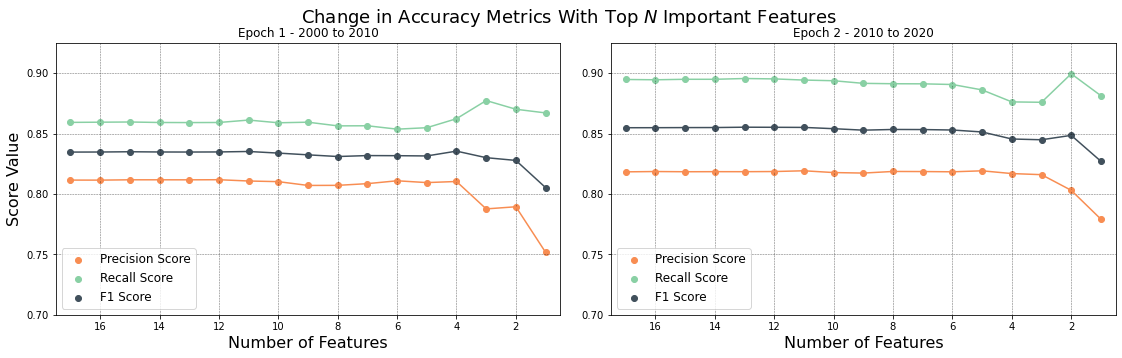

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (19, 5))

# plot points for Epoch 1
ax[0].scatter(x=list(pscore_dict_e1.keys()), y=list(pscore_dict_e1.values()),
          color='#f88d52', label='Precision Score')
ax[0].plot(list(pscore_dict_e1.keys()), list(pscore_dict_e1.values()), color='#f88d52')

ax[0].scatter(x=list(rscore_dict_e1.keys()), y=list(rscore_dict_e1.values()),
          color='#89d0a4', label='Recall Score')
ax[0].plot(list(rscore_dict_e1.keys()), list(rscore_dict_e1.values()), color='#89d0a4')

ax[0].scatter(x=list(fscore_dict_e1.keys()), y=list(fscore_dict_e1.values()),
          color='#41505c', label='F1 Score')
ax[0].plot(list(fscore_dict_e1.keys()), list(fscore_dict_e1.values()), color='#41505c')
ax[0].set_title('Epoch 1 - 2000 to 2010')

#pscore_dict_e2 = {key:pscore_dict_e2[key] for key in sorted(pscore_dict_e2, reverse=True)}

# plot points for Epoch 2
ax[1].scatter(x=list(pscore_dict_e2.keys()), y=list(pscore_dict_e2.values()),
          color='#f88d52', label='Precision Score')
ax[1].plot(list(pscore_dict_e2.keys()), list(pscore_dict_e2.values()), color='#f88d52')

ax[1].scatter(x=list(rscore_dict_e2.keys()), y=list(rscore_dict_e2.values()),
          color='#89d0a4', label='Recall Score')
ax[1].plot(list(rscore_dict_e2.keys()), list(rscore_dict_e2.values()), color='#89d0a4')

ax[1].scatter(x=list(fscore_dict_e2.keys()), y=list(fscore_dict_e2.values()),
          color='#41505c', label='F1 Score')
ax[1].plot(list(fscore_dict_e2.keys()), list(fscore_dict_e2.values()), color='#41505c')
ax[1].set_title('Epoch 2 - 2010 to 2020')


# reverse the plots
for n in range(0, 2):
    ax[n].set_xlim(17.5, 0.5)
    ax[n].set_ylim(0.7, 0.925)

    ax[n].grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.6)
    ax[n].grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
    
    ax[n].set_xlabel("Number of Features", fontsize=16)

    ax[n].legend(loc='lower left')

ax[0].set_ylabel("Score Value", fontsize=16)
    
fig.subplots_adjust(wspace=0.1, hspace=0)
plt.suptitle('Change in Accuracy Metrics With Top $\it{N}$ Important Features', fontsize=18)
plt.rc('legend', fontsize=14)

plt.savefig(r'Images/%s_NFeatures_Accuracies_5Fold_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)

In [24]:
# print the covariates in descending order of coef to find the value to draw line in the feature importance graph
abs_importance_e2 = np.abs(lasso_importances_e2)
print(abs_importance_e2.sort_values(ascending=False))

dist_hospitals       0.992848
2010_VD_K5           0.854485
2010_BD_K13          0.725389
dist_hotels          0.453503
elevation            0.437422
slope                0.359554
2010_BD_K11          0.327262
2010_BD_K5           0.156487
2010_dist_builtup    0.151686
dist_water           0.130460
2010_r1_dist         0.119256
2010_AD_K5           0.114738
2010_BD_K3           0.050506
2010_BD_K9           0.042920
2010_BD_K7           0.029328
2010_r3_dist         0.021527
2010_r2_dist         0.005681
dtype: float64


## Remove less important features, add lat and lon columns, export CSV

In [36]:
GLLR_coef = pd.concat([pd.Series(lasso_importances_e1_plot.index, index=lasso_importances_e1_plot.index), lasso_importances_e1_plot, lasso_importances_e2_plot], axis=1)
GLLR_coef.columns = ['FeatureName', 'Epoch1', 'Epoch2']

print(GLLR_coef)

                   FeatureName    Epoch1    Epoch2
BD_K3                    BD_K3  0.373203  0.050506
BD_K5                    BD_K5  0.109572  0.156487
BD_K7                    BD_K7  0.120300  0.029328
BD_K9                    BD_K9  0.092640  0.042920
BD_K11                  BD_K11  0.001424 -0.327262
BD_K13                  BD_K13  0.419487  0.725389
VD_K5                    VD_K5 -0.377214 -0.854485
AD_K5                    AD_K5 -0.179697 -0.114738
dist_builtup      dist_builtup  0.574130  0.151686
r1_dist                r1_dist  0.231770 -0.119256
r2_dist                r2_dist -0.056903  0.005681
r3_dist                r3_dist -0.121087 -0.021527
dist_hospitals  dist_hospitals  0.618842  0.992848
dist_hotels        dist_hotels  0.192336  0.453503
dist_water          dist_water  0.138824  0.130460
elevation            elevation -0.493682 -0.437422
slope                    slope -0.350840 -0.359554


In [33]:
selected_epoch1_columns = abs_importance_e1.sort_values(ascending=False).head(7)
#print(selected_epoch1_columns)

selected_export_epoch1 = df_epoch1_reduced[selected_epoch1_columns.keys()]
selected_export_epoch1[['latitudes', 'longitudes', 'growth_00_10']] = df.loc[selected_export_epoch1.index, 
                                                                             ['latitudes', 'longitudes', 'growth_00_10']]

print(selected_export_epoch1.head())

        dist_hospitals  2000_dist_builtup  elevation  2000_BD_K13  2000_VD_K5  \
591057        0.887817           0.611018  -0.580719     0.667677   -0.784448   
556143        0.893140           0.653338  -0.610799     2.897769   -0.581843   
739289        0.290820           0.653338  -0.497999     1.353859    0.228574   
513967        0.407450           0.526376  -0.403998    -0.224360    0.735085   
566184        0.925154           0.611018  -0.452879     0.839223   -0.784448   

        2000_BD_K3     slope  latitudes  longitudes  growth_00_10  
591057   -0.452943 -0.969766  3063180.8   342417.97             1  
556143    3.251205 -0.358740  3064200.8   331317.97             1  
739289    2.510375 -0.673647  3058800.8   339297.97             1  
513967   -0.452943 -0.301780  3065460.8   346197.97             1  
566184   -0.452943 -0.585007  3063900.8   327747.97             1  


C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [34]:
selected_epoch2_columns = abs_importance_e2.sort_values(ascending=False).head(6)
#print(selected_epoch2_columns)

selected_export_epoch2 = df_epoch2_reduced[selected_epoch2_columns.keys()]
selected_export_epoch2[['latitudes', 'longitudes', 'growth_10_20']] = df.loc[selected_export_epoch2.index, 
                                                                             ['latitudes', 'longitudes', 'growth_10_20']]

print(selected_export_epoch2.head())

        dist_hospitals  2010_VD_K5  2010_BD_K13  dist_hotels  elevation  \
564089        0.490576   -0.696622     0.221839     0.464493  -0.316210   
494080        0.611368    1.306363    -0.182577     0.526465  -0.579612   
395613        0.696516   -0.696622     0.329684     0.483490  -0.638971   
535650        0.494225    0.104572    -0.586994     0.170028  -0.442346   
470074        0.983079   -0.696622     1.003711     0.970511  -0.638971   

           slope  latitudes  longitudes  growth_10_20  
564089 -0.611329  3063960.8   325857.97             1  
494080 -0.454467  3066030.8   328707.97             1  
395613 -0.664503  3068940.8   331257.97             1  
535650 -0.968599  3064800.8   326127.97             1  
470074 -1.109859  3066750.8   340047.97             1  


C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [25]:
selected_export_epoch1.to_csv('./Tables/%s_Kathmandu_Epoch1_GWLR_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)
selected_export_epoch2.to_csv('./Tables/%s_Kathmandu_Epoch2_GWLR_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)
GLLR_coef.to_csv('./Tables/%s_Kathmandu_GLLR_Coef_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)

## Determine the threshold to remove features, show one extra to estimate the cut off better

In [35]:
print(abs_importance_e1.sort_values(ascending=False).head(8))
print(abs_importance_e2.sort_values(ascending=False).head(7))

e1_vals = abs_importance_e1.sort_values(ascending=False).head(8).values
e2_vals = abs_importance_e2.sort_values(ascending=False).head(7).values

e1_threshold = e1_vals[-1] + (e1_vals[-2] -  e1_vals[-1]) / 2
e2_threshold = e2_vals[-1] + (e2_vals[-2] -  e2_vals[-1]) / 2

print('Threshold for Epoch 1:', round(e1_threshold, 2))
print('Threshold for Epoch 2:', round(e2_threshold, 2))

dist_hospitals       0.618842
2000_dist_builtup    0.574130
elevation            0.493682
2000_BD_K13          0.419487
2000_VD_K5           0.377214
2000_BD_K3           0.373203
slope                0.350840
2000_r1_dist         0.231770
dtype: float64
dist_hospitals    0.992848
2010_VD_K5        0.854485
2010_BD_K13       0.725389
dist_hotels       0.453503
elevation         0.437422
slope             0.359554
2010_BD_K11       0.327262
dtype: float64
Threshold for Epoch 1: 0.29
Threshold for Epoch 2: 0.34


In [39]:
from pylab import *

cmap = cm.get_cmap('Spectral', 5)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#9e0142
#f88d52
#ffffbf
#89d0a4
#5e4fa2


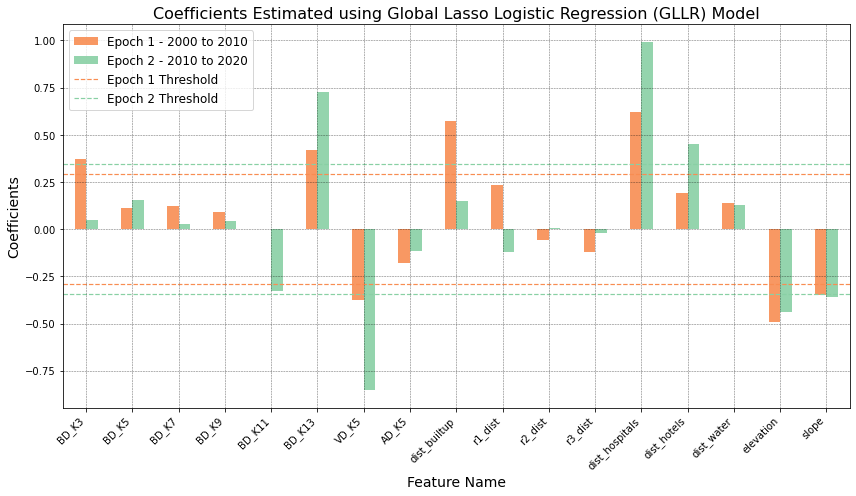

In [43]:
# define the colors for epoch 1 and epoch 2
epoch1_color = '#f88d52'
epoch2_color = '#89d0a4'

#std_epoch1 = np.std([tree.feature_importances_ for tree in lr_epoch1.estimators_], axis=0)
lasso_importances_e1_plot = deepcopy(lasso_importances_e1)
lasso_importances_e1_plot.index = lasso_importances_e1.index.str.replace('2000_', '')

#std_epoch2 = np.std([tree.feature_importances_ for tree in lr_epoch2.estimators_], axis=0)
lasso_importances_e2_plot = deepcopy(lasso_importances_e2)
lasso_importances_e2_plot.index = lasso_importances_e2.index.str.replace('2010_', '')

fig, ax = plt.subplots(figsize = (12, 7))

#importance_df = pd.concat([lr_importances_epoch1.abs(), lr_importances_epoch2.abs()], axis=1)
importance_df = pd.concat([lasso_importances_e1_plot, lasso_importances_e2_plot], axis=1)
importance_df.columns = ['Epoch 1 - 2000 to 2010', 'Epoch 2 - 2010 to 2020']

importance_df.plot.bar(ax=ax, y=["Epoch 1 - 2000 to 2010", "Epoch 2 - 2010 to 2020"], 
                       color={"Epoch 1 - 2000 to 2010":epoch1_color, "Epoch 2 - 2010 to 2020":epoch2_color}, alpha=0.9)

# add threshold line for epoch 1 and 2
ax.axhline(y=e1_threshold, c=epoch1_color, linestyle='--', linewidth=1.2, zorder=1, label='Epoch 1 Threshold')
ax.axhline(y=-e1_threshold, c=epoch1_color, linestyle='--', linewidth=1.2, zorder=1)
ax.axhline(y=e2_threshold, c=epoch2_color, linestyle='--', linewidth=1.2, zorder=1, label='Epoch 2 Threshold')
ax.axhline(y=-e2_threshold, c=epoch2_color, linestyle='--', linewidth=1.2, zorder=1)

ax.set_title("Coefficients Estimated using Global Lasso Logistic Regression (GLLR) Model", fontsize=16)
ax.set_ylabel("Coefficients", fontsize=14)
ax.set_xlabel("Feature Name", fontsize=14)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
# reorder legend entries
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 3, 0, 1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='upper left')
plt.rc('legend', fontsize=12)

ax.grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.2)
ax.grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
#ax.xaxis.grid(False)

plt.savefig(r'Images/%s_GLLR_FeatImportance_BothEpochs_PT_V2.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
fig.tight_layout()

# Tests - Check the number of data points falling in each strata

In [26]:
#df_epoch1_reduced, growth_00_10_bal
df_epoch1 = df[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_built', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
       '2000_r1_dist', '2000_r2_dist', '2000_r3_dist', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope', 'growth_00_10', 'latitudes', 'longitudes']]

# extract non-builtup cells only and remove builtup column
df_epoch1 = df_epoch1.loc[df_epoch1['2000_built'] == 0]
growth_00_10 = df_epoch1['growth_00_10']
#df_epoch1.drop(['2000_built', 'growth_00_10'], axis=1, inplace=True)

df_epoch1 = gpd.GeoDataFrame(df_epoch1, geometry=gpd.points_from_xy(df_epoch1.longitudes, df_epoch1.latitudes))

print(df_epoch1.shape, growth_00_10.shape)

(926549, 24) (926549,)


In [27]:
# Downsample the majority class
unbuilt_features = resample(df_epoch1.loc[growth_00_10==0],
                            replace = False, # sample without replacement
                            n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(growth_00_10.loc[growth_00_10==0],
                          replace = False, # sample without replacement
                          n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                          random_state = 2)

built_features = resample(df_epoch1.loc[growth_00_10==1],
                            replace = False, # sample without replacement
                            n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                            random_state = 2)

built_labels = resample(growth_00_10.loc[growth_00_10==1],
                          replace = False, # sample without replacement
                          n_samples = N_SAMPLES//2, #built_features.shape[0], # match minority n
                          random_state = 2)

print('Epoch 1 - Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Combine the balanced features
gdf_epoch1 = pd.concat([built_features, unbuilt_features], axis=0)
growth_00_10_bal = pd.concat([built_labels, unbuilt_labels], axis=0)

Epoch 1 - Number of records in balanced classes:
Built: 12500, Unbuilt: 12500


319587.97 3051480.8 350037.97 3080610.8


<AxesSubplot:>

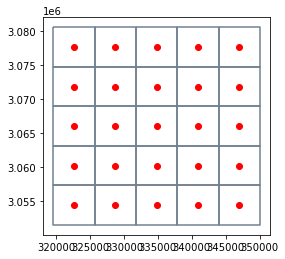

In [28]:
# spatial sampling using mesh
x_min, y_min, x_max, y_max = gdf_epoch1.total_bounds
print(x_min, y_min, x_max, y_max)

# using bounding box, determine the center of the grids for a n by m grid
X_SIZE = 5
Y_SIZE = 5

x_intervals = np.linspace(x_min, x_max, X_SIZE+1)
x_diff = np.diff(x_intervals)
x_centers = np.arange((x_min + x_diff[0]/2), (0.001 + x_max - x_diff[0]/2), x_diff[0])

y_intervals = np.linspace(y_min, y_max, Y_SIZE+1)
y_diff = np.diff(y_intervals)
y_centers = np.arange((y_min + y_diff[0]/2), (0.001 + y_max - y_diff[0]/2), y_diff[0])

# create points geodataframe
mesh_x_centers = np.meshgrid(x_centers, y_centers)[0].flatten()
mesh_y_centers = np.meshgrid(x_centers, y_centers)[1].flatten()
mesh_centroids = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(mesh_x_centers, mesh_y_centers))

# define a function to create rectangular buffer
def rectangle_buffer(point, x_dist, y_dist):
    min_lon = point.x - x_dist
    max_lon = point.x + x_dist
    min_lat = point.y - y_dist
    max_lat = point.y + y_dist
    
    lon_list = [min_lon, max_lon, max_lon, min_lon, min_lon]
    lat_list = [max_lat, max_lat, min_lat, min_lat, max_lat]
    
    return Polygon(zip(lon_list, lat_list))

mesh_gdf = gpd.GeoDataFrame([], geometry=mesh_centroids.geometry.apply(
    lambda x: rectangle_buffer(x, x_diff[0]/2, y_diff[0]/2))
                               )

# Plot the results
fig, ax1 = plt.subplots()
mesh_centroids.plot(ax = ax1, color = 'red')
mesh_gdf.boundary.plot(ax=ax1, color = 'slategrey')

In [29]:
n = 0
for index, row in mesh_gdf.iterrows():
    spatial_strata = gpd.clip(gdf_epoch1, row.geometry)
    n_1 = spatial_strata.loc[spatial_strata.growth_00_10==1].shape[0]
    n_0 = spatial_strata.shape[0] - n_1


    # perform random sampling
    growth = spatial_strata.loc[spatial_strata.growth_00_10==1]
    non_growth = spatial_strata.loc[spatial_strata.growth_00_10==0]
    print('Iter %d. No. of growth: %d, non_growth: %d' % (n, growth.shape[0], non_growth.shape[0]))
    
    n += 1
    

Iter 0. No. of growth: 94, non_growth: 596
Iter 1. No. of growth: 388, non_growth: 517
Iter 2. No. of growth: 535, non_growth: 544
Iter 3. No. of growth: 146, non_growth: 582
Iter 4. No. of growth: 1, non_growth: 572
Iter 5. No. of growth: 14, non_growth: 581
Iter 6. No. of growth: 798, non_growth: 444
Iter 7. No. of growth: 1568, non_growth: 269
Iter 8. No. of growth: 933, non_growth: 494
Iter 9. No. of growth: 343, non_growth: 581
Iter 10. No. of growth: 358, non_growth: 544
Iter 11. No. of growth: 1502, non_growth: 393
Iter 12. No. of growth: 1689, non_growth: 59
Iter 13. No. of growth: 1449, non_growth: 362
Iter 14. No. of growth: 355, non_growth: 543
Iter 15. No. of growth: 58, non_growth: 584
Iter 16. No. of growth: 91, non_growth: 540
Iter 17. No. of growth: 1699, non_growth: 367
Iter 18. No. of growth: 440, non_growth: 541
Iter 19. No. of growth: 29, non_growth: 595
Iter 20. No. of growth: 12, non_growth: 525
Iter 21. No. of growth: 16, non_growth: 603
Iter 22. No. of growth: 9

KeyError: 'n_0'

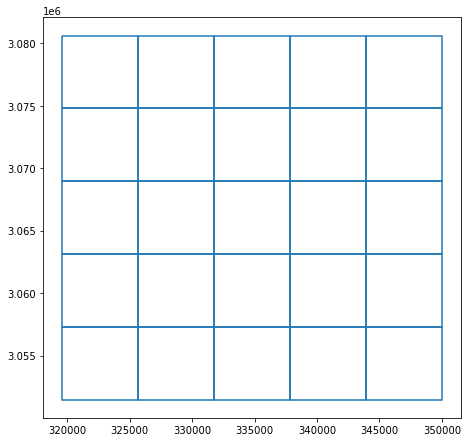

In [30]:
ax = mesh_gdf.geometry.boundary.plot(figsize=(7.5, 7.5))
mesh_gdf.apply(lambda x: ax.annotate(text='n_0=' + str(x['n_0']) + '\n\n' + 'n_1=' + str(x['n_1']), xy=x.geometry.centroid.coords[0], 
                                     ha='center', va='center'), axis=1)

#plt.savefig('../Images/220206_SpatialStrata_PT_V1.png', dpi=300, format='PNG', bbox_inches='tight', pad_inches = 0)
#plt.close(fig)